In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the CSV file
# Replace 'chienloup.csv' with the exact path to your file
data = pd.read_csv('chienloup.csv', sep=';')

# Extract quantitative and qualitative variables names
quantitative_vars = data.columns[1:-1]  # Quantitative variables
qualitative_var = data.columns[-1]     # Qualitative variable (e.g., category)


# Group the data by the qualitative variable
groups = data.groupby(qualitative_var)

# Initialize a dictionary to store intra-class covariance matrices
W_k_dict = {}

W = np.zeros((len(quantitative_vars), len(quantitative_vars)))

# Identify numerical columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Apply StandardScaler to numerical columns
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Compute W_k for each group as well as W
for group_name, group in groups:
    group_values = group[quantitative_vars].values
    group_mean = np.mean(group_values, axis=0)
    n_k = group_values.shape[0]  # Number of samples in the group
    # Calculate W_k: intra-class covariance matrix
    W_k = (group_values - group_mean).T @ (group_values - group_mean) / n_k
    W_k_dict[group_name] = W_k  # Store each W_k with the corresponding group name
    W += W_k * n_k

W = W/data.shape[0]




###(Bonus)############################################################################################################################
# We compute and visualize the correlation matrix from the covariance matrix to interpret the values of the intra covariances
#for group_name, W_k in W_k_dict.items():
#    print(f"Intra-class correlation matrix W_k for group '{group_name}':")
#    # Computation of the correlation matrix from the covariance matrix
#    std_dev = np.sqrt(np.diag(W_k))  # Standard deviations
#    correlation_matrix = W_k / np.outer(std_dev, std_dev)  # Normalize to get correlations
#
#    # Visualization of the correlation matrix
#    plt.figure(figsize=(8, 6))
#    plt.imshow(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1)
#    plt.colorbar(label="Correlation")
#    plt.xticks(ticks=range(len(quantitative_vars)), labels=quantitative_vars, rotation=45, ha="right")
#    plt.yticks(ticks=range(len(quantitative_vars)), labels=quantitative_vars)
#    plt.title("Correlation Matrix Heatmap")
#    plt.tight_layout()
#    plt.show()
#
####################################################################################################################################



# Computation of inter-class covariance matrix (B), which measures variability between group means
overall_mean = np.mean(data[quantitative_vars].values, axis=0)  # Overall mean vector
B = np.zeros((len(quantitative_vars), len(quantitative_vars)))  # Initialize inter-class covariance matrix

for name, group in groups:
    group_size = len(group)  # Number of samples in the current group
    group_mean = np.mean(group[quantitative_vars].values, axis=0)  # Mean vector of the group
    diff = (group_mean - overall_mean).reshape(-1, 1)  # Difference vector reshaped as a column
    B += group_size * (diff @ diff.T)  # Weighted outer product of the difference vector

# Computation of total variance matrix (V) as the sum of intra-class (W) and inter-class (B) covariances
V = W + B

# Displaying intra-class (W), inter-class (B), and total variance (V) matrices
print(f"Total intra-class covariance matrix (W):")
print(pd.DataFrame(W, index=quantitative_vars, columns=quantitative_vars))
print("\n")
print("\nTotal inter-class covariance matrix (B):")
print(pd.DataFrame(B, index=quantitative_vars, columns=quantitative_vars))
print("\nTotal variance matrix (V):")
print(pd.DataFrame(V, index=quantitative_vars, columns=quantitative_vars))

Total intra-class covariance matrix (W):
          LCB       LSM         LBM      LP        LM         LAM
LCB    0.939981  0.882055  0.299871  0.410150  0.548646  0.432191
LSM    0.882055  0.896673  0.136196  0.392458  0.511276  0.390752
 LBM   0.299871  0.136196  0.960426  0.203936  0.211339  0.228455
LP     0.410150  0.392458  0.203936  0.304173  0.311178  0.233331
LM     0.548646  0.511276  0.211339  0.311178  0.512851  0.346395
LAM    0.432191  0.390752  0.228455  0.233331  0.346395  0.597031



Total inter-class covariance matrix (B):
          LCB        LSM         LBM       LP         LM          LAM
LCB    2.520813   3.307508  2.046919   8.583128   7.181678   6.531770
LSM    3.307508   4.339716  2.685722  11.261752   9.422938   8.570206
 LBM   2.046919   2.685722  1.662114   6.969566   5.831578   5.303847
LP     8.583128  11.261752  6.969566  29.224736  24.452933  22.240056
LM     7.181678   9.422938  5.831578  24.452933  20.460268  18.608709
LAM    6.531770   8.570206  5.303

Coumputation of V^-1.B and its eigen values

In [96]:
# Compute the trace of B and V
trace_B = np.trace(B)  # Sum of diagonal elements of B
trace_V = np.trace(V)  # Sum of diagonal elements of V

# Display the results
print(f"Trace of Inter-class covariance matrix (B): {trace_B}")
print(f"Trace of Total variance matrix (V): {trace_V}")

# Compare the traces
print(f"Proportion of variance explained by inter-class variability: {trace_B / trace_V:.2%}")

Trace of Inter-class covariance matrix (B): 333191.90952380927
Trace of Total variance matrix (V): 432160.2126984125
Proportion of variance explained by inter-class variability: 77.10%


Interpretation of V, W, B:
The inter-class variance, which is the trace of B, accounts for 0.77% of the total variance. This shows that the original variables separate the classes' groups quite well.

Computation of V^-1 * B

In [97]:
# Compute V^-1 * B
V_inv = np.linalg.inv(V)
V_inv_B = V_inv @ B

# Compute the eigenvalues of V^-1 * B
eigenvalues, _ = np.linalg.eig(V_inv_B)

# Display the eigenvalues and their sum
print("Eigenvalues of V^-1 * B:\n", eigenvalues)
print("\nSum of eigenvalues:", np.sum(eigenvalues))

Eigenvalues of V^-1 * B:
 [ 9.94925042e-01+0.00000000e+00j  2.27611276e-14+0.00000000e+00j
  1.38879934e-14+0.00000000e+00j -7.47444178e-15+3.77105478e-15j
 -7.47444178e-15-3.77105478e-15j -1.41794016e-15+0.00000000e+00j]

Sum of eigenvalues: (0.9949250416627787+0j)


2) Etudiez les matrices V-1 et B : dimension, caractéristiques : Pouvez toujours diagonaliser directement 𝑉
−1𝐵 ?

In [ ]:
# Study the matrices
print("Dimension of V^-1:", V_inv.shape)
print("Dimension of B:", B.shape)


# Study V^-1 * B
print("Dimension of V^-1 * B:", V_inv_B.shape)

# Compute the rank of V^-1 * B
rank_V_inv_B = np.linalg.matrix_rank(V_inv_B)

# Compute the condition number (high values indicate collinearity)
cond_number = np.linalg.cond(V_inv_B)


# Display results
print("Rank of V^-1 * B:", rank_V_inv_B)
print("Condition number of V^-1 * B:", cond_number)


Dimension of V^-1: (6, 6)
Dimension of B: (6, 6)
Dimension of V^-1 * B: (6, 6)
Rank of V^-1 * B: 4
Condition number of V^-1 * B: 9773931263870940.0


Commentary on V-1.B diagonalisation

In [99]:
# We observe that the rank computed for V^-1 * B is 4, while its size is 6x6. ()
# This indicates that the collinearity between its columns is so high that the computer estimates it as a set of nearly collinear vectors.
# This is further confirmed by the very high value of the condition number.

# This indicates numerical instability, which suggests that the matrix is close to being non-invertible.

# In conclusion, V^-1 * B is not always invertible due to high collinearity between its columns.
# This is caused by the low rank of B, which determines the rank of V^-1 * B. 
# In this case, since the number of classes is q = 2, the rank of B is at most q-1 = 1.
# The above computed value of 4 for V^-1.B rank is due to wrong approximation made by the computer of the eigen values that are = 0 but estimated as slightly higher.

3) Si vous choisissez de diagonalisation cette matrice, utiliser le complément sur la diagonalisation donnée en cours
(technique de régularisation). Apres diagonalisation comme en ACP vous obtiendrez la projection des individus dans
un nouvel espace par une méthode factorielle par projections.

In [100]:


# Step 1: Use SVD for decomposition of B into CC^T
U, S, _ = np.linalg.svd(B)  # SVD of B
C = U @ np.diag(np.sqrt(S))  # Construct C

# Compute the matrix C'Σ^(-1)C
C_T = C.T  # Transpose of C
C_Sigma_inv_C_T = C_T @ V_inv @ C

# Check if the matrix is symmetric (it should be)
# print("Is C'Σ^(-1)C symmetric?:", np.allclose(C_Sigma_inv_C_T, C_Sigma_inv_C_T.T))

# Diagonalize the symmetric matrix C'Σ^(-1)C
eigenvalues, eigenvectors = np.linalg.eigh(C_Sigma_inv_C_T)  # eigh ensures symmetric diagonalization

# Compute the transformation vector v using equation 
v_vectors = V_inv @ C @ eigenvectors


# Sort eigen values index scaling order
sorted_indices = np.argsort(eigenvalues)[::-1]  # [::-1] pour inverser l'ordre (croissant -> décroissant)

# Sort eigen values and eigen vectors in descending order
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = v_vectors[:, sorted_indices]

# Results
print("Eigenvalues of :", sorted_eigenvalues)

print("Transformed eigenvectors (v):")
print(pd.DataFrame(sorted_eigenvectors))


Eigenvalues of : [9.94925042e-01 3.95012658e-14 1.52139095e-14 8.80691405e-15
 6.42928785e-16 1.39501568e-16]
Transformed eigenvectors (v):
          0             1             2             3             4  \
0  0.000322 -3.089727e-09  2.179188e-10  7.728942e-10  3.010178e-11   
1 -0.000007  5.452425e-09 -6.730519e-10 -1.585857e-09  1.038420e-10   
2  0.000148  1.624950e-09  3.818129e-11 -5.305035e-10  2.024900e-10   
3 -0.006930 -1.464096e-08 -3.949594e-09 -3.276762e-09 -1.664707e-10   
4 -0.001474  1.823370e-08  2.065761e-08  4.273595e-09 -7.792539e-10   
5 -0.000866  3.823911e-09 -5.881198e-09  4.157703e-09  1.601900e-11   

              5  
0 -2.301619e-11  
1 -3.184599e-11  
2  1.051378e-10  
3 -2.023918e-11  
4  9.731309e-11  
5  4.407285e-11  


Projection of X onto the space spanned by eigen vectors explaining at least 80% of the variance

Number of components to explain 80% of variance: 1
Cumulative explained variance: [1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1]


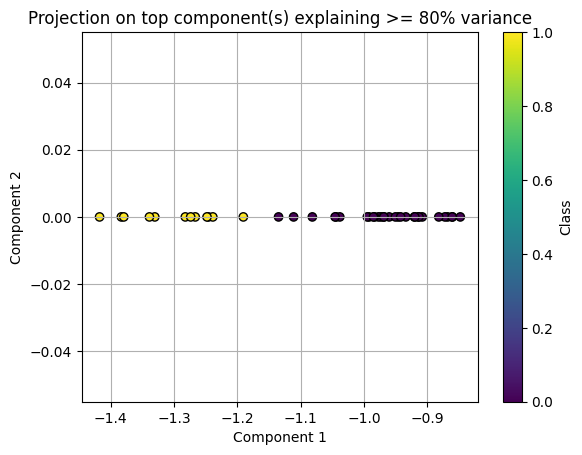

In [101]:
# Step 2: Calculate the explained variance
explained_variance_ratio = sorted_eigenvalues / np.sum(sorted_eigenvalues)  # Explained variance ratio
cumulative_explained_variance = np.cumsum(explained_variance_ratio)  # Cumulative explained variance

# Find the number of components needed to explain at least 80% of the variance
n_components = np.argmax(cumulative_explained_variance >= 0.8) + 1

print(f"Number of components to explain 80% of variance: {n_components}")
print("Cumulative explained variance:", cumulative_explained_variance)

# Step 3: Select the top n_components eigenvectors
selected_v_vectors = sorted_eigenvectors[:, :n_components]

# Step 4: Project the data onto the selected eigenvectors
Z = data[quantitative_vars] @ selected_v_vectors  

# Step 5: Visualize the projection
# Convert the qualitative variable to binary (one-hot encoding)
binary_labels = data[qualitative_var].map({'CHIEN': 0, 'LOUP': 1}).values
print(binary_labels)
if Z.shape[1] == 1:
    plt.scatter(Z, [0] * Z.shape[0], c=binary_labels, cmap='viridis', edgecolor='k')
else:
    plt.scatter(Z[:, 0], Z[:, 1], c= binary_labels, cmap='viridis', edgecolor='k') 

plt.title("Projection on top component(s) explaining >= 80% variance")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Class")
plt.grid()
plt.show()

Commentary of the projection on the new plan:

In [102]:
# We can see that the component choosen to project the individuals very well splits the class groups. 
# For values > -1.25 all the individuals are dogs, and for values < -1.25 are Wolfs